In [1]:
# Make division and print() behave like Python 3 even if 
# using Python 2.x:
from __future__ import print_function, division

# Import the key packages we need:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# Make default font a bit bigger:
import matplotlib
matplotlib.rcParams['font.size'] = 18   # Font size in points

from astropy.table import Table
from astropy.constants import iau2015 as const
from astropy import units as u
from astropy.time import Time

import orbits

# Plots show in the notebook, not pop-up:
%matplotlib inline


29.900881337122712


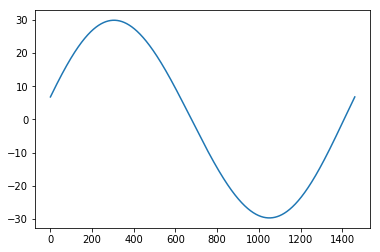

In [2]:
#Quantities of earth orbit viewed from a specific position
d_pc = 10 #pc
parallax = 1/d_pc

P = 1 #yr
e = 0.01671022
T = 1 #yr
a_AU = 1.00000011 #AU
a_arcsec = orbits.au2arcsec(a_AU, d_pc)
i = np.deg2rad(90) #deg
w = np.deg2rad(102.94719) #deg
Omega = np.deg2rad(-11.26064) #deg

A, B, F, G, C, H = orbits.Thiele_Innes_from_Campbell(w, a_arcsec, i, Omega, parallax=parallax)

num_obs = 1461

times = P*np.arange(num_obs)/(num_obs - 1)

ra, dec, radvel = orbits.keplerian_xy_Thiele_Innes(times, A, B, F, G, T, e, P, C=C, H=H)

radvel_km_sec = radvel*(149600000000/1000)/(365.256*24*60*60)
print(np.max(radvel_km_sec))

plt.plot(radvel_km_sec)
plt.show()

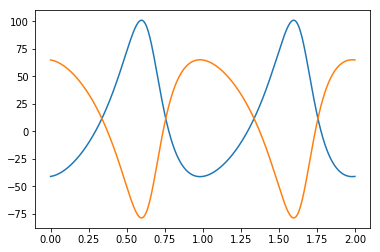

In [3]:
#Eq.8 L14
#HD 224355
#Lester et al. 2019
P = 0.033304547945
T = 2004.7555
e = 0.3117
a = 0.002392
i = np.radians(97.1)
w = np.radians(34.46)
Omega = np.radians(219.4)
k1 = 71.11
k2 = 71.90
gamma = 11.74

rat1 = k1/(k1+k2)
rat2 = k2/(k1+k2)

d_pc = 63.98
parallax = 1/d_pc

A, B, F, G, C, H = orbits.Thiele_Innes_from_Campbell(w, a, i, Omega, parallax=parallax)

num_obs = 1461
times = 2*P*np.arange(num_obs)/(num_obs-1)
    
ra_theo, dec_theo, radvel_theo = orbits.keplerian_xy_Thiele_Innes(times, A, B, F, G, T, e, P, C=C, H=H)

radvel_km_sec = radvel_theo*(149600000000/1000)/(365.256*24*60*60)

radvel1 = rat1*radvel_km_sec
radvel2 = rat2*radvel_km_sec

Phase = times/P

plt.plot(Phase, -radvel1+gamma)
plt.plot(Phase, radvel2+gamma)
plt.show()

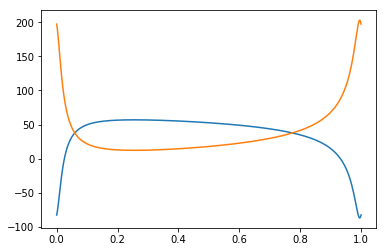

In [36]:
#Eq.8 L14
#Sigma Orionis A,B
#Schaefer et al. 2018
P_d = 143.2002
P_yr = P_d/365.256
T0 = 56597.638 + 2.4e6
T0 = Time(T0, format='jd')
T0 = T0.jyear
e = 0.77896
a = 0.0042860 
i = np.radians(56.378)
w = np.radians(199.83)
Omega = np.radians(6.878)
k1 = 72.03
k2 = 95.53
gamma = 37.63

# Calculate velocity ratios
rat1 = k1/(k1+k2)
rat2 = k2/(k1+k2)

d_pc = 387.5
parallax = 1/d_pc

A, B, F, G, C, H = orbits.Thiele_Innes_from_Campbell(w, a, i, Omega, parallax=parallax)

num_obs = 1461
times = P_yr*np.arange(num_obs)/(num_obs-1)

#Set T0 to 0 here as times is 0 when the phase is 0 as per the equation immediaely above
ra_theo, dec_theo, radvel_theo = orbits.keplerian_xy_Thiele_Innes(times, A, B, F, G, 0, e, P_yr, C=C, H=H)
radvel_km_sec = orbits.AUyr2Kms(radvel_theo)

# Apply ratios to theoreticl velocity
radvel1 = rat1*radvel_km_sec
radvel2 = rat2*radvel_km_sec

Phase = times/P_yr

plt.plot(Phase, -radvel1+gamma)
plt.plot(Phase, radvel2+gamma)
plt.show()


Gamma from fitting of VA,a:  37.058615145477575
K value from fitting of VA,a:  61.01866954343581

Gamma from fitting of VA,b:  35.6321806483631
K value from fitting of VA,b:  -99.3944868039012



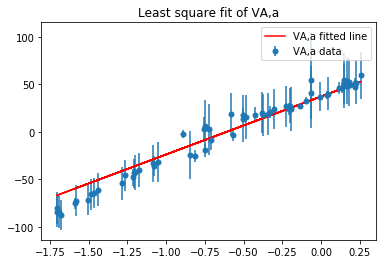

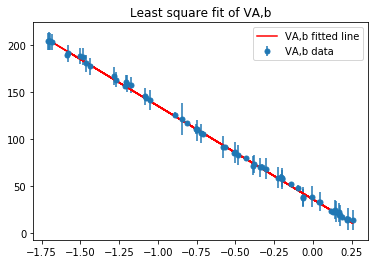

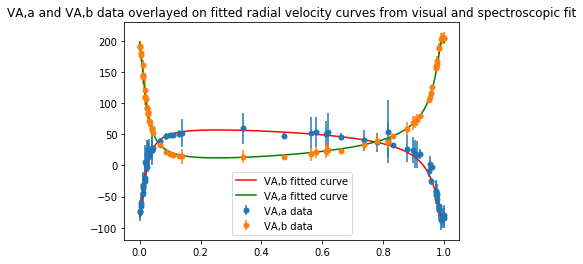

In [37]:
def v_fraction(times, P, T, e, w):
    
    M = (2*np.pi/P)*(times-T)
    E = orbits.getE_parallel(M, e)
    v_frac = (np.cos(w)*np.cos(E)*(1-e**2)-np.sin(w)*np.sin(E)*np.sqrt(1-e**2))/(1-e*np.cos(E))
    return v_frac

#Sigma Orionis A,B
#Schaefer et al. 2018
P_d = 143.2002
P_yr = P_d/365.256
T0 = 56597.638 + 2.4e6
T0 = Time(T0, format='jd')
T0 = T0.jyear
e = 0.77896
a = 0.0042860 
i = np.radians(56.378)
w = np.radians(199.83)
Omega = np.radians(6.878)

datafile = "Orionis_rv.txt"
data = Table.read(datafile, format='ascii.commented_header')

times_HJD = data['HJD']
va = data['Va']
vb = data['Vb']
va_errs = data['Va_err']
vb_errs = data['Vb_err']

times_HJD = times_HJD + 2.4e6
times_HJD = Time(times_HJD, format='jd')
times_yr = times_HJD.jyear
times_remainder = (times_yr-T0)%P_yr
phase = times_remainder/P_yr

# Get x-values from times, i.e the value k is multiplied by at each time
x = v_fraction(times_yr, P_yr, T0, e, w)

ya = va
yb = vb

a_gamma, ka = np.polynomial.polynomial.polyfit(x, ya, 1, w=1/va_errs**2)
b_gamma, kb = np.polynomial.polynomial.polyfit(x, yb, 1, w=1/vb_errs**2)

print()
print("Gamma from fitting of VA,a: ", a_gamma)
print("K value from fitting of VA,a: ", ka)
print()
print("Gamma from fitting of VA,b: ", b_gamma)
print("K value from fitting of VA,b: ", kb) #Note that this is EXACTLY what CTIO RV obtains for KA,b
print()

plt.title("Least square fit of VA,a")
plt.plot(x, ka*x + a_gamma, 'r', label='VA,a fitted line')
plt.errorbar(x, ya, yerr=va_errs, fmt='o', label='VA,a data', markersize=5)
plt.legend()
plt.show()

plt.title("Least square fit of VA,b")
plt.plot(x, kb*x + b_gamma, 'r', label='VA,b fitted line')
plt.errorbar(x, yb, yerr=vb_errs, fmt='o', label='VA,b data', markersize=5)
plt.legend()
plt.show()

plt.title("VA,a and VA,b data overlayed on fitted radial velocity curves from visual and spectroscopic fit")
plt.plot(Phase, -radvel1+gamma, 'r', label='VA,b fitted curve')
plt.plot(Phase, radvel2+gamma, 'g', label='VA,a fitted curve')
plt.errorbar(phase, va, yerr=va_errs, fmt='o', label='VA,a data', markersize=5)
plt.errorbar(phase, vb, yerr=vb_errs, fmt='o', label='VA,b data', markersize=5)
plt.legend()
plt.show()